# Stats and summaries

This is a helper notebook for custom visualisation of stats exported from wandb.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

FIGURES_DIR = Path("figures")
STATS_DIR_CLEAN = Path("stats/clean")

FIGURES_DIR.mkdir(exist_ok=True)
STATS_DIR_CLEAN.mkdir(exist_ok=True, parents=True)

Wandb setup:

In [7]:
import os
import wandb

api_key = os.getenv("WANDB_API_KEY")
if not api_key:
    wandb.login()
api = wandb.Api(api_key=api_key);

## n-CPS

### n-CPS n=2 learning rate and weight decay sweep

Collecting data from wandb:

In [3]:
# Filter by tag
runs = api.runs(
    "DL-gr82/semi-supervised-ensembles",
    filters={"tags": "ncps-gcn-n2-lr"}
)

# Extract data
target_epoch = 349
data = []
for run in runs:
    # Need to take epoch 350 as first runs were longer
    history = run.history()
    epoch_data = history.iloc[target_epoch]
    data.append({
        "run_id": run.id,
        "run_name": run.name,
        "seed": run.config["seed"],
        "val_mse": epoch_data["val_MSE"],
        "model": run.config["model"]["init"]["_target_"],
        "cps_loss_weight": run.config["trainer"]["init"]["cps_loss_weight"],
        "lr": run.config["trainer"]["init"]["optimizer"][0]["lr"],
        "weight_decay": run.config["trainer"]["init"]["optimizer"][0]["weight_decay"],
        "num_models": run.config["trainer"]["num_models"],
    })
df = pd.DataFrame(data)
out = STATS_DIR_CLEAN / "ncps-gcn-n2-lr-wd-sweep.csv"
df.to_csv(out)

Plot n-CPS with n = 2 learning rate and weight decay sweep:

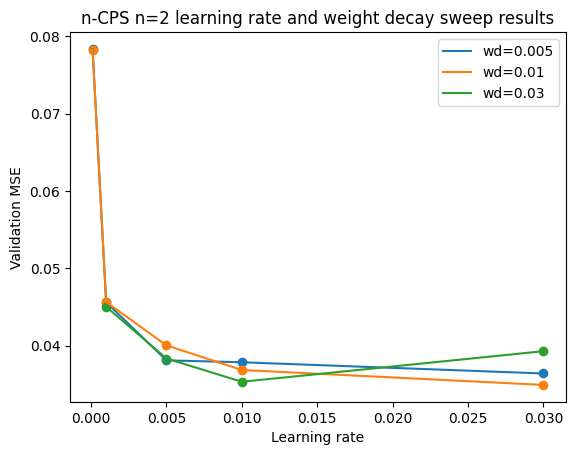

In [4]:
df = pd.read_csv(STATS_DIR_CLEAN / "ncps-gcn-n2-lr-wd-sweep.csv", quotechar="\"")

df = df.sort_values(by="lr")
fig, ax = plt.subplots()
ax.set_title("n-CPS n=2 learning rate and weight decay sweep results")
for wd in df["weight_decay"].unique():
    df_sub = df[df["weight_decay"] == wd]
    ax.scatter(df_sub["lr"], df_sub["val_mse"])
    ax.plot(df_sub["lr"], df_sub["val_mse"], label=f"wd={wd}")
    ax.set_xlabel("Learning rate")
    ax.set_ylabel("Validation MSE")
plt.savefig(FIGURES_DIR / "ncps-gcn-n2-lr-wd-sweep.png")
plt.legend();

n-CPS with n = 2 CPS loss weight $\lambda$ sweep results:

In [5]:
# Filter by tag
runs = api.runs(
    "DL-gr82/semi-supervised-ensembles",
    filters={
        "tags": "ncps-gcn-n2-lambda-sweep",
        "state": "finished"
    }
)

# Extract data
data = []
print(f"Runs found: {len(runs)}")
for run in runs:
    opt = run.config["trainer"]["init"]["optimizer"]
    # Handle when it"s a list (there"s always only one item)
    if not isinstance(opt, dict):
        if len(opt) != 1:
            raise ValueError("Found multiple optimizers, aborting")
        opt = opt[0]

    data.append({
        "run_id": run.id,
        "run_name": run.name,
        "seed": run.config["seed"],
        "val_mse": run.summary["val_MSE"],
        "model": run.config["model"]["init"]["_target_"],
        "cps_loss_weight": run.config["trainer"]["init"]["cps_loss_weight"],
        "lr": opt["lr"],
        "weight_decay": opt["weight_decay"],
        "num_models": run.config["trainer"]["num_models"],
    })
df = pd.DataFrame(data)
out = STATS_DIR_CLEAN / "ncps-gcn-n2-cps-loss-weight-sweep.csv"
df.to_csv(out)

Runs found: 14


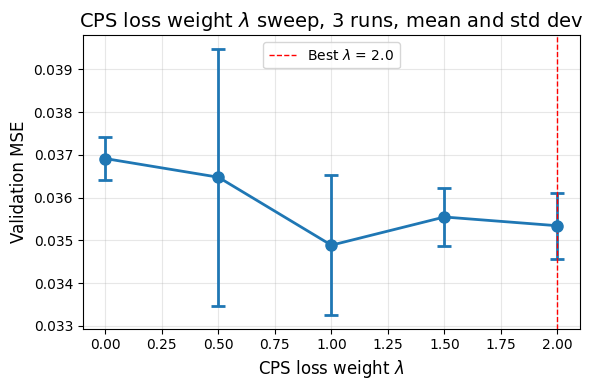

In [6]:
df = pd.read_csv(STATS_DIR_CLEAN / "ncps-gcn-n2-cps-loss-weight-sweep.csv", quotechar="\"")

grouped = df.groupby("cps_loss_weight")["val_mse"].agg(["mean", "std"]).reset_index()
grouped["score"] = grouped["mean"] + grouped["std"]
# print(grouped)
# Plot with error bars
fig, ax = plt.subplots(figsize=(6, 4), layout="tight")
ax.errorbar(
    grouped["cps_loss_weight"], 
    grouped["mean"], 
    yerr=grouped["std"],
    fmt="o-",
    capsize=5,
    capthick=2,
    markersize=8,
    linewidth=2,
)
best_val = grouped.loc[grouped["score"].idxmin()]["cps_loss_weight"]
ax.axvline(best_val, c="red", linestyle="--", linewidth=1, label=rf"Best $\lambda$ = {best_val}")

ax.set_xlabel(r"CPS loss weight $\lambda$", fontsize=12)
ax.set_ylabel("Validation MSE", fontsize=12)
ax.set_title(r"CPS loss weight $\lambda$ sweep, 3 runs, mean and std dev", fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()
plt.savefig(FIGURES_DIR / "ncps-gcn-n2-cps-loss-weight-sweep.png")
# plt.savefig(FIGURES_DIR / "ncps-gcn-n2-cps-loss-weight-sweep2.png", dpi=300, bbox_inches="tight")